In [1]:
import matplotlib.pyplot as plt
import process_data
import pandas as pd
import numpy as np
from get_log_time import get_log_tags_dataframe, tag_name_to_value, get_dummy_log_tags_dataframe
from process_data import get_log_files, get_log_files_dataframe, get_log_tags_dataframe, \
    clean_log_dataframe, add_query_id_node_id_dataframe, get_msg_id_to_batch_id_dict, \
    add_batch_id_to_all_compute, compute_task_times, global_search_udl_times, dummy_udl_times, dummy_no_deserialize_udl_times, dummy_no_op_times


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload


In [4]:
plt.rcParams["font.monospace"][0]

'DejaVu Sans Mono'

need to graph all the data collected mate

In [5]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [6]:
def get_dataframes_from_dummy_no_op_log_files(data_folder):
    suffix = ".dat"
    log_files = get_log_files(data_folder, suffix)
    print(log_files)
    df = get_log_files_dataframe(log_files)
    
    log_tags_df = get_dummy_log_tags_dataframe()
    print(log_tags_df)
    tag_fn = lambda tag_name: tag_name_to_value(log_tags_df, tag_name)
    df = clean_log_dataframe(df)
    
    df, abnormal_rows = add_query_id_node_id_dataframe(df, log_tags_df)
    print(df)
    client_send_time = dummy_no_op_times(df, tag_fn)
    return client_send_time

In [7]:
def get_dataframes_from_dummy_log_files(data_folder):
    suffix = ".dat"
    log_files = get_log_files(data_folder, suffix)
    print(log_files)
    df = get_log_files_dataframe(log_files)
    
    log_tags_df = get_dummy_log_tags_dataframe()
    print(log_tags_df)
    tag_fn = lambda tag_name: tag_name_to_value(log_tags_df, tag_name)
    df = clean_log_dataframe(df)
    
    df, abnormal_rows = add_query_id_node_id_dataframe(df, log_tags_df)
    print(df)
    batch_send_latency, put_and_forget_time, udl_handler_time, udl_handler_bytes_df = dummy_udl_times(df, tag_fn)
    return batch_send_latency, put_and_forget_time, udl_handler_time, udl_handler_bytes_df

def get_dataframes_from_dummy_no_deserialize_log_files(data_folder):
    suffix = ".dat"
    log_files = get_log_files(data_folder, suffix)
    print(log_files)
    df = get_log_files_dataframe(log_files)
    
    log_tags_df = get_dummy_log_tags_dataframe()
    print(log_tags_df)
    tag_fn = lambda tag_name: tag_name_to_value(log_tags_df, tag_name)
    df = clean_log_dataframe(df)
    
    df, abnormal_rows = add_query_id_node_id_dataframe(df, log_tags_df)
    print(df)
    batch_send_latency, put_and_forget_time, udl_handler_time, udl_handler_bytes_df = dummy_udl_times(df, tag_fn)
    return batch_send_latency, put_and_forget_time, udl_handler_time, udl_handler_bytes_df
    

In [8]:
def get_dataframes_from_log_files(data_folder):
    suffix = ".dat"
    log_files = get_log_files(data_folder, suffix)
    df = get_log_files_dataframe(log_files)
    
    log_tags_df = get_log_tags_dataframe()
    tag_fn = lambda tag_name: tag_name_to_value(log_tags_df, tag_name)
    
    df = clean_log_dataframe(df)
    df, abnormal_rows = add_query_id_node_id_dataframe(df, log_tags_df)
    
    msg_id_to_batch_id_dict = get_msg_id_to_batch_id_dict(df, tag_fn)
    # print(msg_id_to_batch_id_dict)
    conflicts = add_batch_id_to_all_compute(df, msg_id_to_batch_id_dict)
    
    roundtrip_durations, query_send_to_serialize_durations, batch_serialization_time, batch_send_latency,\
        put_and_forget_time, transfer_messages_time, prep_batch_serialize_time, batch_deserialize_time,\
        query_pushed_to_start_time, compute_query_time, compute_result_push_time, compute_result_to_serialize_time \
        = compute_task_times(df, tag_fn)
    
    search_read_df, search_step_df, global_udl_handler_time_df, global_udl_handler_bytes_df,\
        push_message_time_df = global_search_udl_times(df, tag_fn)

    return roundtrip_durations, query_send_to_serialize_durations, batch_serialization_time, batch_send_latency,\
        put_and_forget_time, transfer_messages_time, prep_batch_serialize_time, batch_deserialize_time,\
        query_pushed_to_start_time, compute_query_time, compute_result_push_time, compute_result_to_serialize_time, \
        search_read_df, search_step_df, global_udl_handler_time_df, global_udl_handler_bytes_df,\
        push_message_time_df

In [9]:
def get_summary_stats(df, column_name):
    s =df[column_name]
    
    return {"count": s.count(), 
            "mean": s.mean(), 
            "std": s.std(), 
            "median": s.quantile(0.50), 
            "p90": s.quantile(0.90), 
            "p99":s.quantile(0.99)}

def visualize_dataframe(df, y_column_name,y_label, ax_0 ,ax_1):
    ax_0.scatter(df["timestamp"], df[y_column_name], s = 0.15, alpha = 0.5)
    ax_0.set_xlabel("start timestamp")
    ax_0.set_ylabel(y_label)
    start_x = 0.8
    start_y = 0.9
    y_diff = 0.1
    fontsize = 10
    for stat_name, stat in get_summary_stats(df, y_column_name).items():
        ax_0.text(x = start_x, y = start_y, s =f"{stat_name:7}{stat:.2f}",transform=ax_0.transAxes, fontsize = fontsize, fontname = 'monospace')
        start_y = start_y - y_diff
    latency = df[y_column_name].to_numpy()
    # filtered_latency = latency[~is_outlier(latency)]
    ax_1.hist(latency, 50)
    ax_1.set_ylabel("number of occurrences")
    ax_1.set_xlabel(y_label)


def visualize_duration_dataframe(df, ax_0, ax_1):
    visualize_dataframe(df, "latency", "us", ax_0, ax_1)

def visualize_extra_dataframe(df, y_label, ax_0, ax_1):
    visualize_dataframe(df, "extra", y_label, ax_0, ax_1)
    
def visualize_frequency(df, ax):
    # Convert microseconds to seconds
    timestamps_seconds = df["timestamp"] / 1_000_000  # 1 million microseconds = 1 second
    
    # Create 1-second bins
    start_time = timestamps_seconds.min()
    end_time = timestamps_seconds.max()
    
    # Create bins at 1-second intervals
    bins = np.arange(int(start_time), int(end_time) + 2, 1)
    
    ax.hist(timestamps_seconds, bins=bins)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Frequency') 

now we need to graph everything in a grid, need the main suspects of the latency: 
- roundtrip durations
- batch send latency
- time for when compute query is pushed to queue to when its popped off for compute
- Time from putting a compute query/result onto the batching thread queue to it being serialized
- udl handler times



In [10]:
def graph_data_from_dummy_no_op_log_files(data_folder, png_output_path): 
    client_send_time = get_dataframes_from_dummy_no_op_log_files(data_folder)
    print("client send time",client_send_time)
    summary_fig, axes = plt.subplots(2, 2)
    summary_fig.set_size_inches(15, 10) 
    axes[0, 0].set_title("batch send latency")
    visualize_duration_dataframe(client_send_time, axes[0, 0], axes[0, 1])
    # axes[0, 0].set_ylim(3000, 5000)
    # axes[1, 0].set_title(" udl handler completion time")
    # visualize_duration_dataframe(udl_handler_time, axes[1, 0], axes[1, 1])
    # # axes[2, 0].set_title("number of bytes in a batch")
    # # visualize_extra_dataframe(global_udl_handler_bytes_df, "number of bytes in batch",axes[2, 0], axes[2, 1])
    # axes[2, 0].set_title("put_and_forget time")
    # visualize_duration_dataframe(put_and_forget_time, axes[2, 0], axes[2, 1])
    # axes[3, 0].set_title("number of bytes in batch")
    # visualize_extra_dataframe(udl_handler_bytes_df, "num bytes in batch",axes[3, 0], axes[3, 1])
    # axes[4, 0].set_title("frequency of batch sending requests")
    # visualize_frequency(put_and_forget_time, axes[4, 0])
    summary_fig.tight_layout()
    summary_fig.savefig(png_output_path, dpi=300)

In [11]:
def graph_data_from_dummy_no_deserialize_log_files(data_folder, png_output_path): 
    batch_send_latency, put_and_forget_time, udl_handler_time, udl_handler_bytes_df = get_dataframes_from_dummy_no_deserialize_log_files(data_folder)
    summary_fig, axes = plt.subplots(5, 2)
    summary_fig.set_size_inches(15, 20) 
    axes[0, 0].set_title("batch send latency")
    visualize_duration_dataframe(batch_send_latency, axes[0, 0], axes[0, 1])
    axes[1, 0].set_title(" udl handler completion time")
    visualize_duration_dataframe(udl_handler_time, axes[1, 0], axes[1, 1])
    # axes[2, 0].set_title("number of bytes in a batch")
    # visualize_extra_dataframe(global_udl_handler_bytes_df, "number of bytes in batch",axes[2, 0], axes[2, 1])
    axes[2, 0].set_title("put_and_forget time")
    visualize_duration_dataframe(put_and_forget_time, axes[2, 0], axes[2, 1])
    axes[3, 0].set_title("number of bytes in batch")
    visualize_extra_dataframe(udl_handler_bytes_df, "num bytes in batch",axes[3, 0], axes[3, 1])
    axes[4, 0].set_title("frequency of batch sending requests")
    visualize_frequency(put_and_forget_time, axes[4, 0])
    summary_fig.tight_layout()
    summary_fig.savefig(png_output_path, dpi=300)

In [12]:
def graph_data_from_dummy_log_files(data_folder, png_output_path): 
    batch_send_latency, put_and_forget_time, udl_handler_time, udl_handler_bytes_df = get_dataframes_from_dummy_log_files(data_folder)
    print("done getting data")
    summary_fig, axes = plt.subplots(5, 2)
    summary_fig.set_size_inches(20, 15) 
    axes[0, 0].set_title("batch send latency")
    visualize_duration_dataframe(batch_send_latency, axes[0, 0], axes[0, 1])
    axes[1, 0].set_title(" udl handler completion time")
    visualize_duration_dataframe(udl_handler_time, axes[1, 0], axes[1, 1])
    # axes[2, 0].set_title("number of bytes in a batch")
    # visualize_extra_dataframe(global_udl_handler_bytes_df, "number of bytes in batch",axes[2, 0], axes[2, 1])
    axes[2, 0].set_title("put_and_forget time")
    visualize_duration_dataframe(put_and_forget_time, axes[2, 0], axes[2, 1])
    axes[3, 0].set_title("number of bytes in batch")
    visualize_extra_dataframe(udl_handler_bytes_df, "num bytes in batch", axes[3, 0], axes[3, 1])
    axes[4, 0].set_title("frequency of batch sending requests")
    visualize_frequency(put_and_forget_time, axes[4, 0])
    summary_fig.savefig(png_output_path, dpi=300)

In [13]:
def graph_data_from_log_files(data_folder, png_output_path):
    roundtrip_durations, query_send_to_serialize_durations, batch_serialization_time, batch_send_latency,\
        put_and_forget_time, transfer_messages_time, prep_batch_serialize_time, batch_deserialize_time,\
        query_pushed_to_start_time, compute_query_time, compute_result_push_time, compute_result_to_serialize_time, \
        search_read_df, search_step_df, global_udl_handler_time_df, global_udl_handler_bytes_df,\
        push_message_time_df = get_dataframes_from_log_files(data_folder)
    summary_fig, axes = plt.subplots(10, 2)
    summary_fig.set_size_inches(15, 20) 
    axes[0, 0].set_title("roundtrip compute latency")
    visualize_duration_dataframe(roundtrip_durations, axes[0, 0], axes[0, 1])
    axes[1, 0].set_title("batch send latency")
    visualize_duration_dataframe(batch_send_latency, axes[1, 0], axes[1, 1])
    axes[2, 0].set_title("compute query pushed to start latency")
    visualize_duration_dataframe(query_pushed_to_start_time, axes[2, 0], axes[2, 1])
    axes[3, 0].set_title("compute query pushed to serialize latency")
    visualize_duration_dataframe(query_send_to_serialize_durations, axes[3, 0], axes[3, 1])
    axes[4, 0].set_title("compute result pushed to serialize latency")
    visualize_duration_dataframe(compute_result_to_serialize_time, axes[4, 0], axes[4, 1])
    axes[5, 0].set_title("global udl handler completion time")
    visualize_duration_dataframe(global_udl_handler_time_df, axes[5, 0], axes[5, 1])
    axes[6, 0].set_title("number of bytes in a batch")
    visualize_extra_dataframe(global_udl_handler_bytes_df, "number of bytes in batch",axes[6, 0], axes[6, 1])
    axes[7, 0].set_title("put_and_forget time")
    visualize_duration_dataframe(put_and_forget_time, axes[7, 0], axes[7, 1])
    axes[8, 0].set_title("frequency of batch sending requests")
    visualize_frequency(put_and_forget_time, axes[8, 0])
    axes[9, 0].set_title("compute query time")
    visualize_duration_dataframe(compute_query_time, axes[9, 0], axes[9, 1])
    summary_fig.tight_layout()
    summary_fig.savefig(png_output_path, dpi=300)
    return 

['/home/nam/workspace/rdma_anns/remote_data/rdma/dummy/node1_udls_timestamp.dat', '/home/nam/workspace/rdma_anns/remote_data/rdma/dummy/node2_udls_timestamp.dat', '/home/nam/workspace/rdma_anns/remote_data/rdma/dummy/node0_udls_timestamp.dat']
                     tag_name  tag_value msg_id_type
0  LOG_DUMMY_BATCH_SEND_START      10000    batch_id
1    LOG_DUMMY_BATCH_SEND_END      10001    batch_id
2     LOG_DUMMY_HANDLER_START      10010    batch_id
3       LOG_DUMMY_HANDLER_END      10011    batch_id
         tag     timestamp        client_node_id                msg_id  extra  \
0      10010  1.757887e+15  18446744073709551615   1651187691921315972     34   
1      10011  1.757887e+15  18446744073709551615   1651187691921315972     34   
2      10000  1.757887e+15  18446744073709551615     68269645277691259      0   
3      10001  1.757887e+15  18446744073709551615     68269645277691259      0   
4      10010  1.757887e+15  18446744073709551615   6378733215142310464     34   
...  

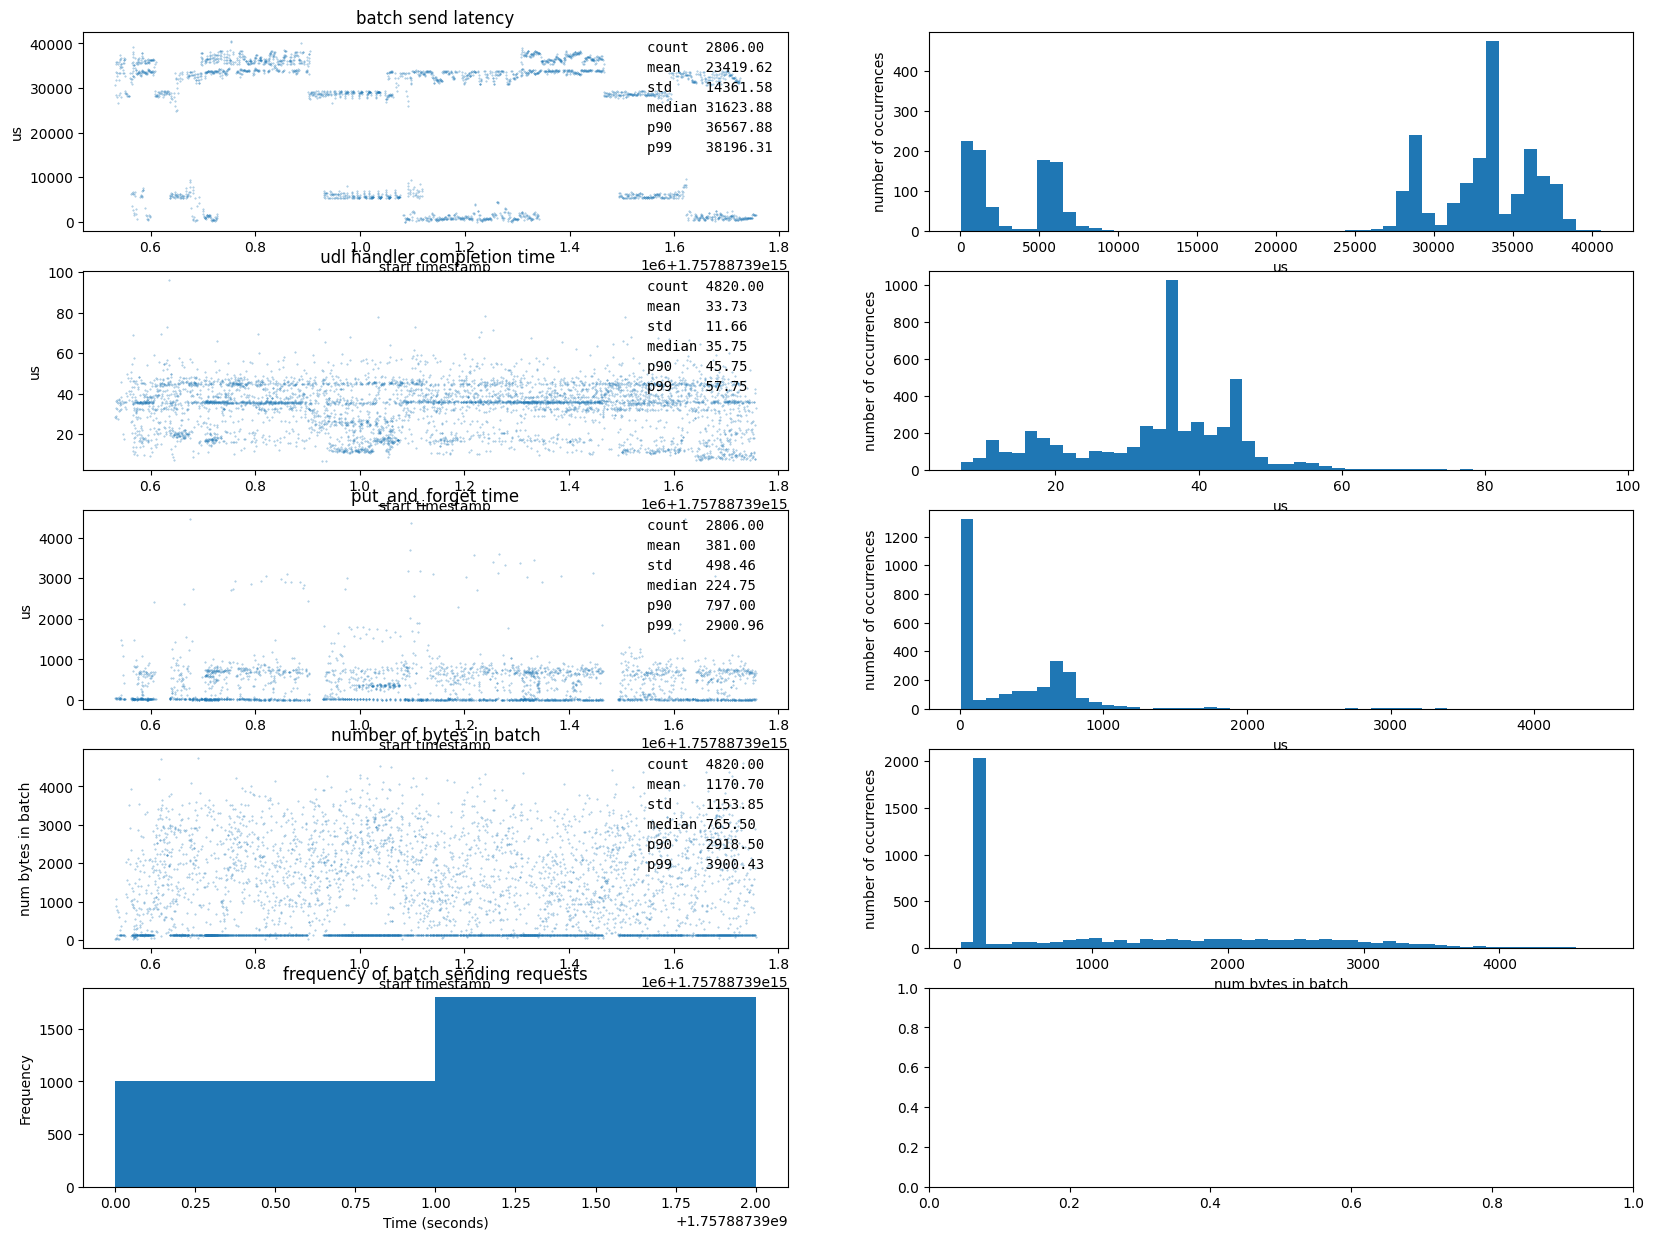

In [26]:
graph_data_from_dummy_log_files("/home/nam/workspace/rdma_anns/remote_data/rdma/dummy/", "bruh.png")

['/home/nam/workspace/rdma_anns/remote_data/rdma/dummy_no_deserialize_1_msg/node1_udls_timestamp.dat', '/home/nam/workspace/rdma_anns/remote_data/rdma/dummy_no_deserialize_1_msg/node2_udls_timestamp.dat', '/home/nam/workspace/rdma_anns/remote_data/rdma/dummy_no_deserialize_1_msg/node0_udls_timestamp.dat']
                     tag_name  tag_value msg_id_type
0  LOG_DUMMY_BATCH_SEND_START      10000    batch_id
1    LOG_DUMMY_BATCH_SEND_END      10001    batch_id
2     LOG_DUMMY_HANDLER_START      10010    batch_id
3       LOG_DUMMY_HANDLER_END      10011    batch_id
4       LOG_CLIENT_SEND_START      20000    batch_id
      tag     timestamp        client_node_id                msg_id  extra  \
0   10011  1.757890e+15  18446744073709551615  11095294583871592410   3158   
1   10010  1.757890e+15  18446744073709551615   2426565442869211412   4208   
2   10011  1.757890e+15  18446744073709551615   2426565442869211412   4208   
3   10010  1.757890e+15  18446744073709551615  1472524073407322

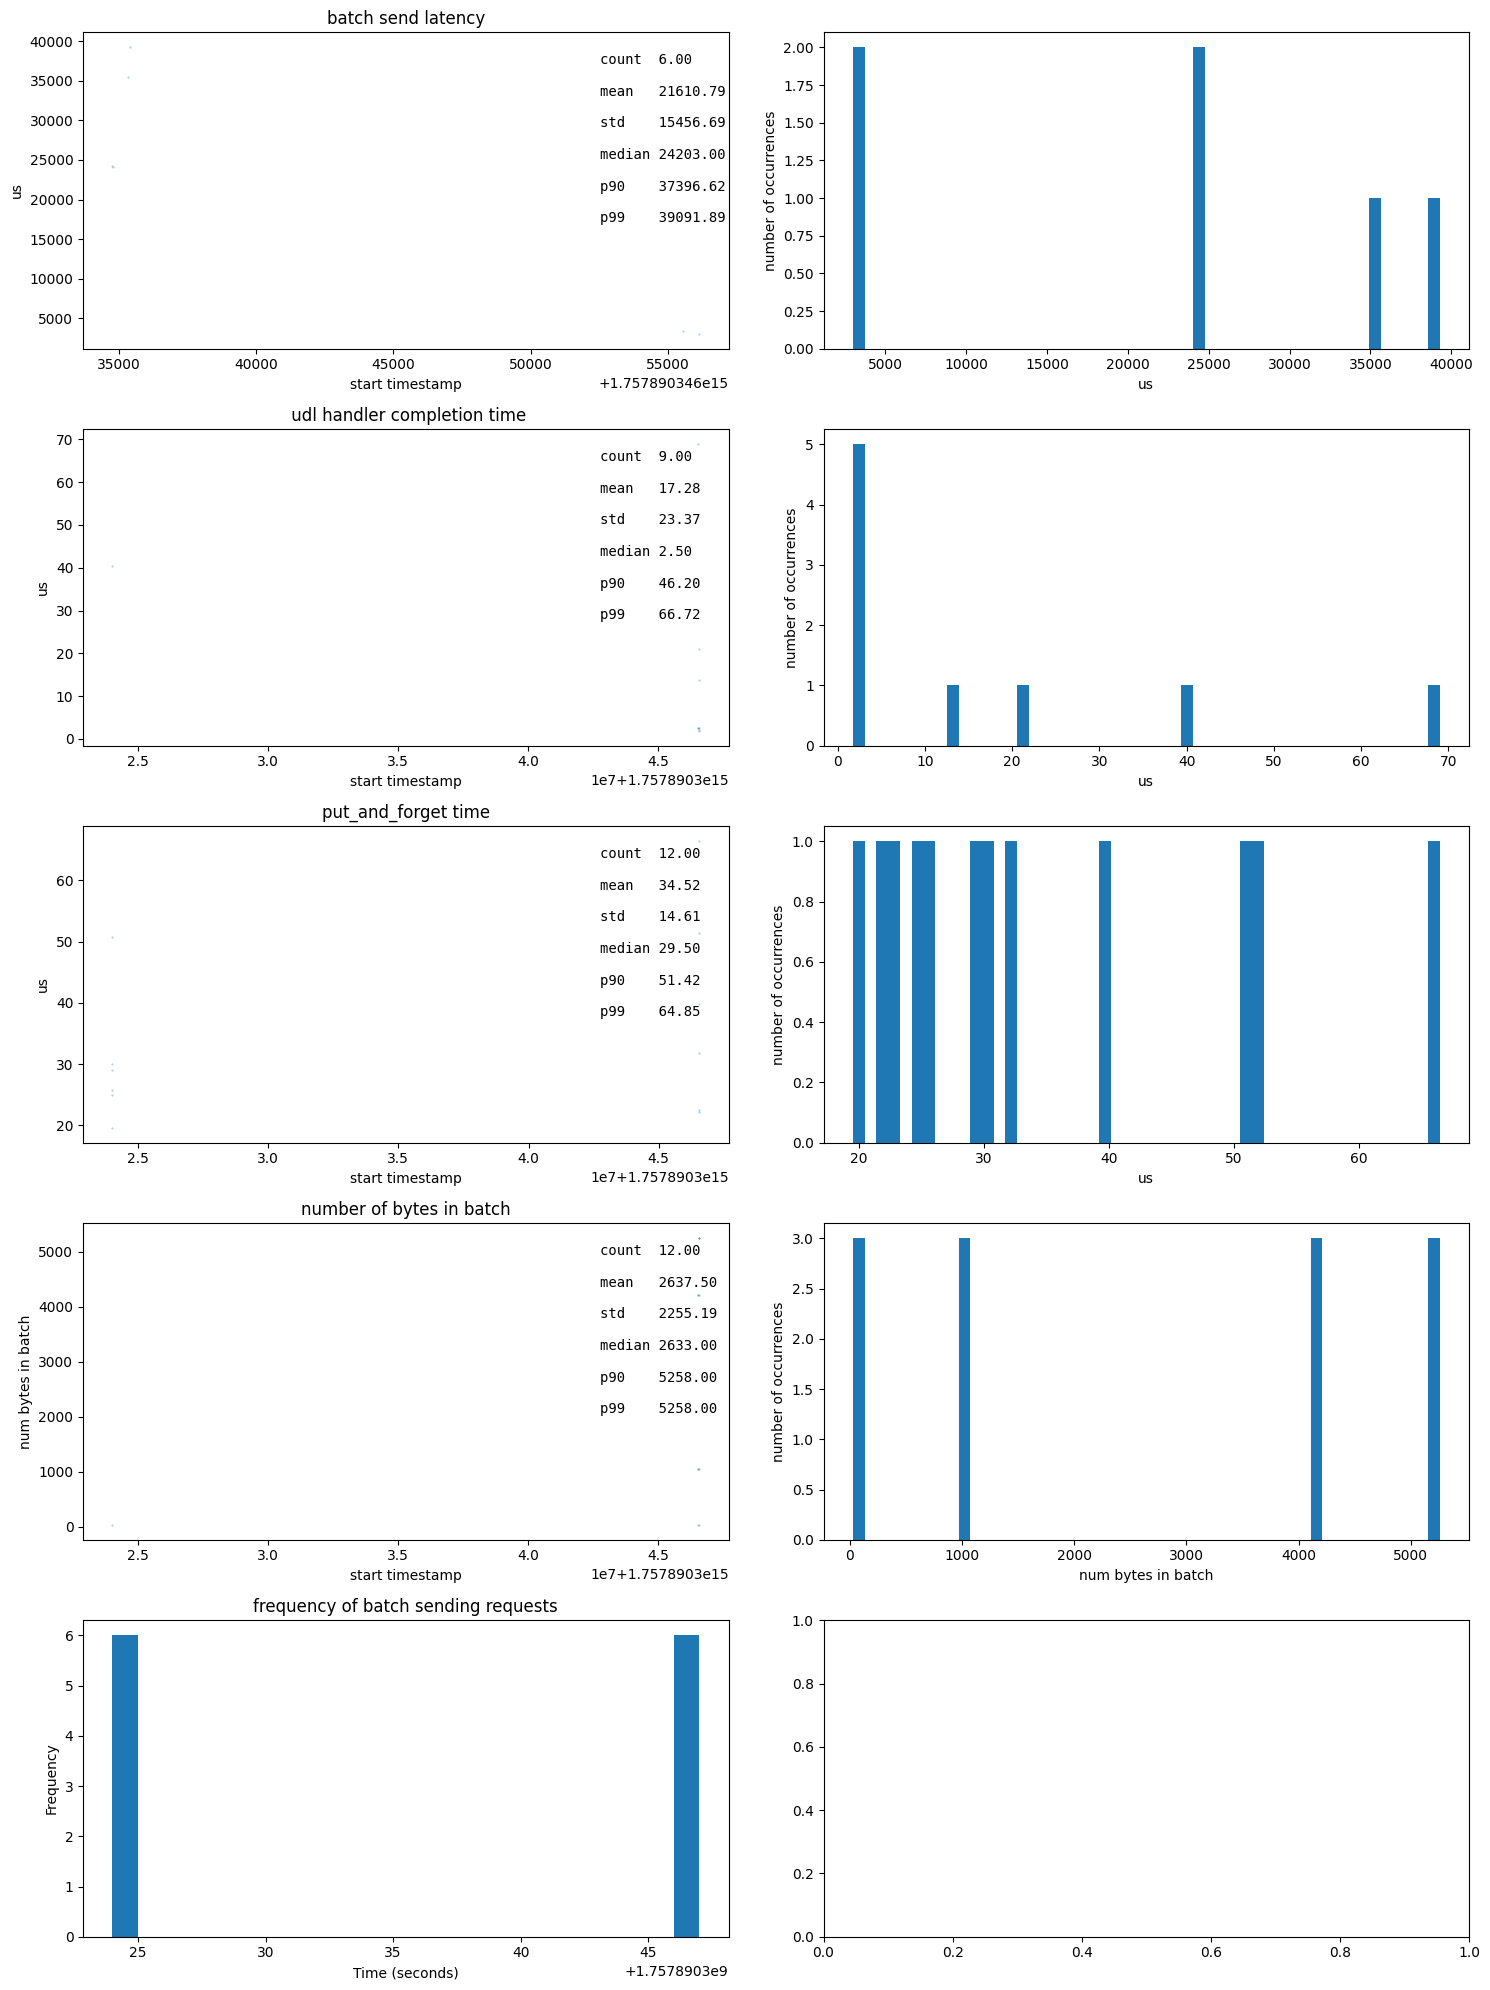

In [18]:
graph_data_from_dummy_no_deserialize_log_files("/home/nam/workspace/rdma_anns/remote_data/rdma/dummy_no_deserialize_1_msg/", "dummy_no_seria.png")

['/home/nam/workspace/rdma_anns/build/dummy_udl/cfg_no_op/n0/node0_udls_timestamp.dat', '/home/nam/workspace/rdma_anns/build/dummy_udl/cfg_no_op/n2/client2.dat']
                     tag_name  tag_value msg_id_type
0  LOG_DUMMY_BATCH_SEND_START      10000    batch_id
1    LOG_DUMMY_BATCH_SEND_END      10001    batch_id
2     LOG_DUMMY_HANDLER_START      10010    batch_id
3       LOG_DUMMY_HANDLER_END      10011    batch_id
4       LOG_CLIENT_SEND_START      20000    batch_id
         tag     timestamp  client_node_id                msg_id  extra  \
0      10010  1.757912e+15               2   6526158324373079329    500   
1      10010  1.757912e+15               2  13359627236789863141    500   
2      10010  1.757912e+15               2    997638428365762336    500   
3      10010  1.757912e+15               2   5336628441285126947    500   
4      10010  1.757912e+15               2   3571207482232396103    500   
...      ...           ...             ...                   ...    ..

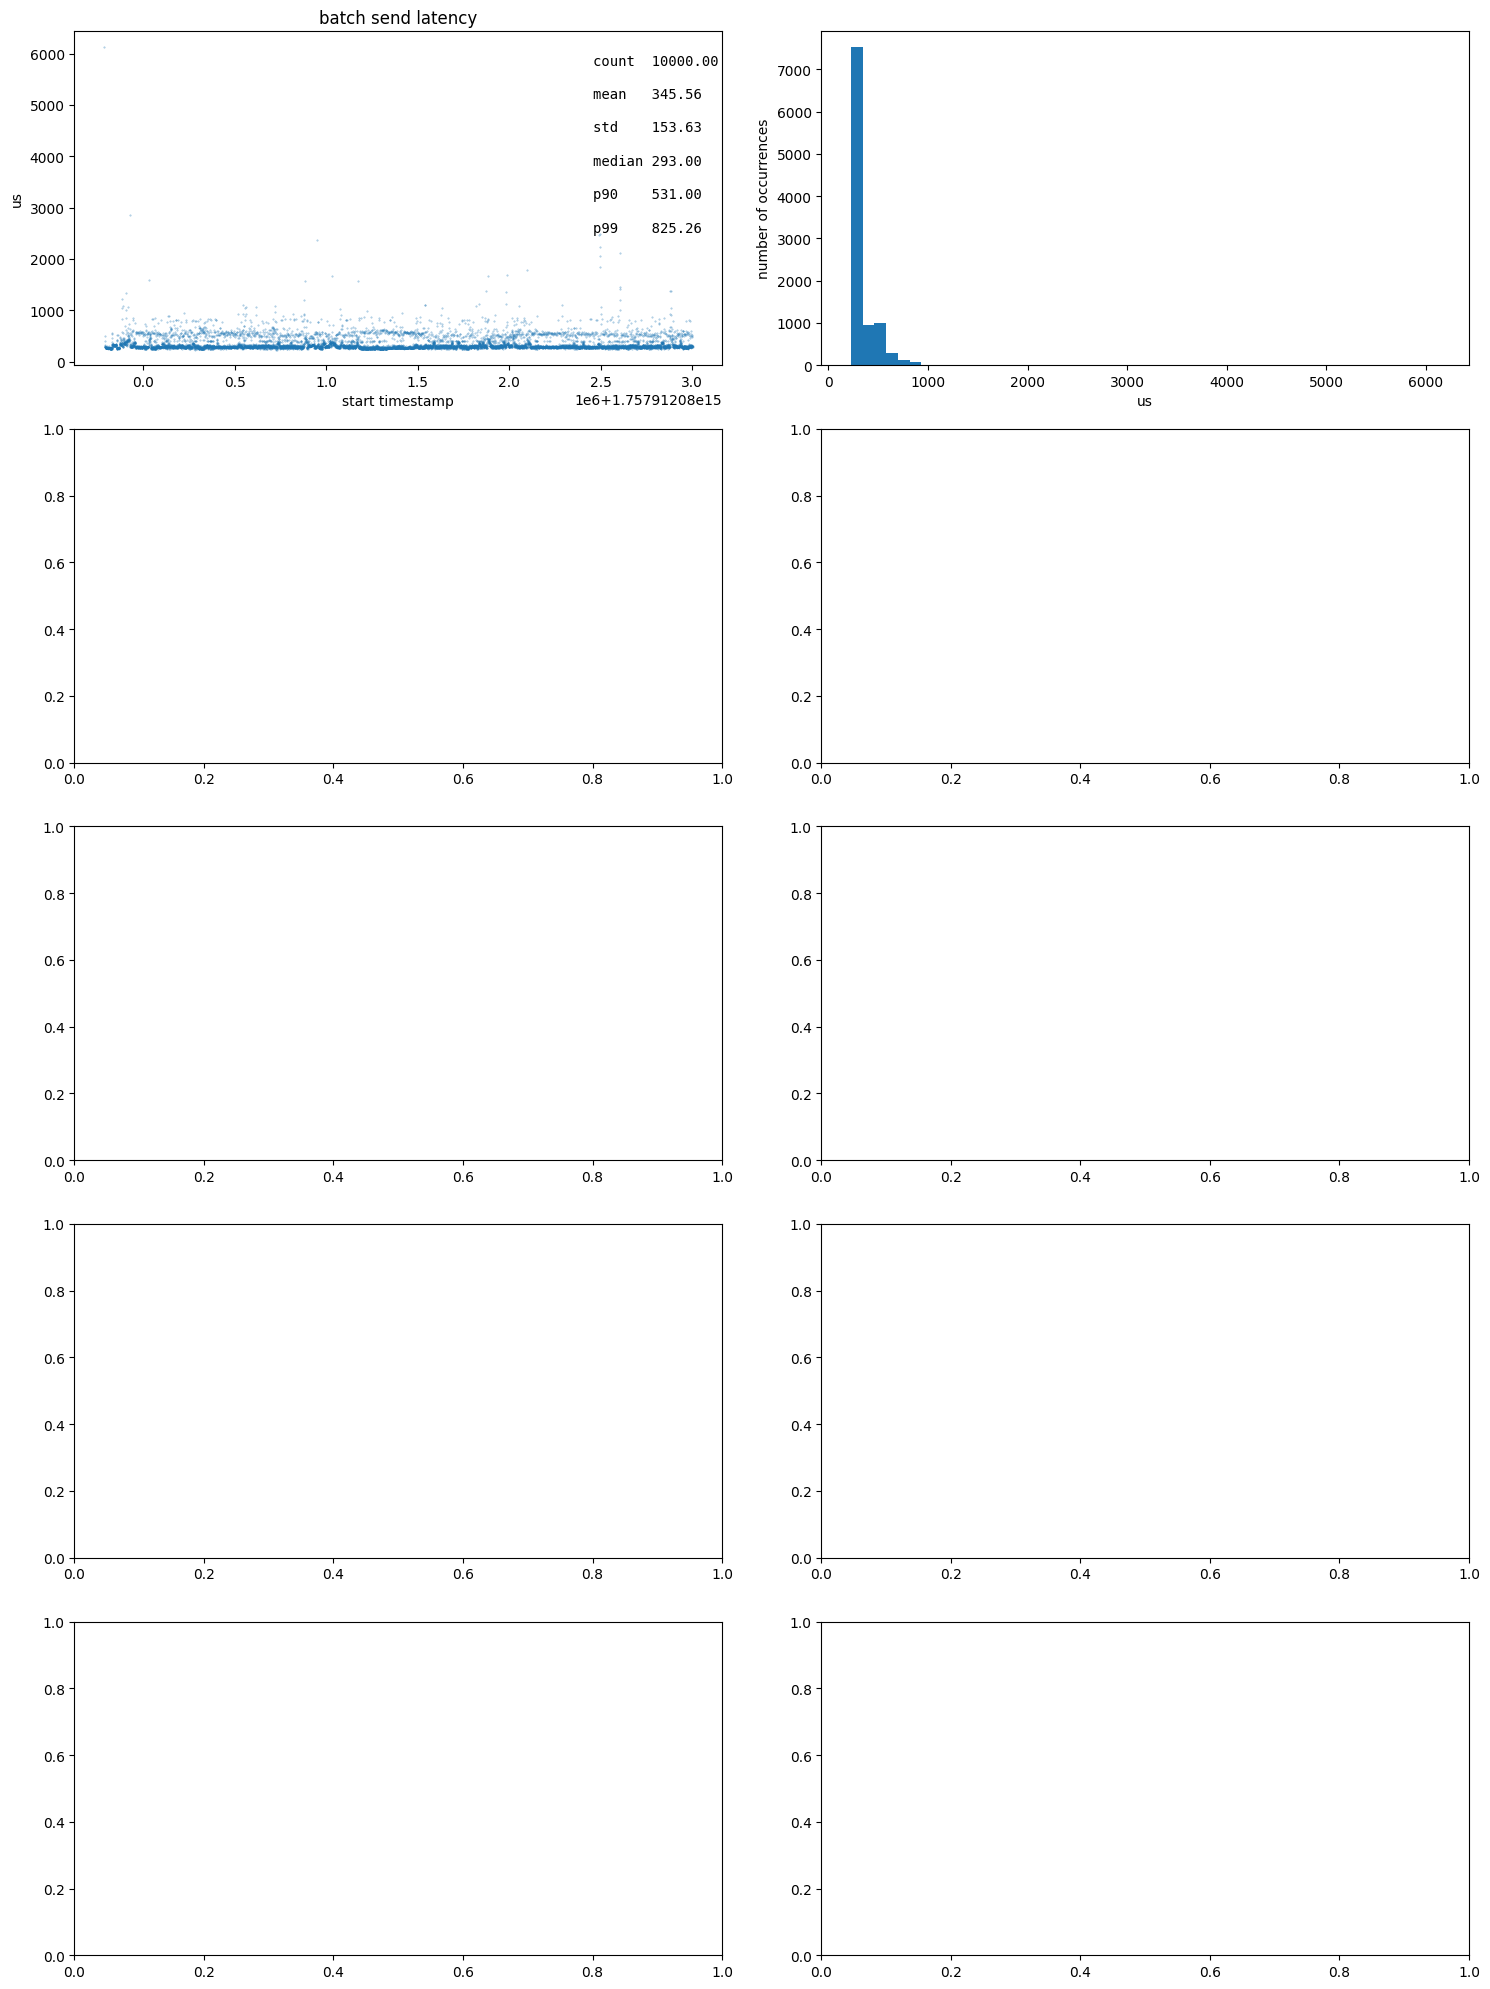

In [19]:
graph_data_from_dummy_no_op_log_files("/home/nam/workspace/rdma_anns/build/dummy_udl/cfg_no_op/", "noop.png")